In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#분류 random forest
from sklearn.ensemble import GradientBoostingClassifier as GBC
#데이터 분할
from sklearn.model_selection import train_test_split
#confusion matrix
from sklearn.metrics import confusion_matrix

import graphviz
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV

In [2]:
matplotlib.rc('font', family = 'NanumGothic')

In [3]:
df_raw = pd.read_csv('/home/piai/Downloads/HMEQ.csv', engine = 'python')
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


### 결측치 제거

In [4]:
df_raw['JOB'].value_counts()
#결측치 대체 함수. 
#JOB 변수의 결측치는 other 로 대체
df_raw['JOB'].fillna('Other', inplace = True)

#숫자형 변수의 결측치는 해당 변수의 평균값 입력
df_raw.fillna(df_raw.mean(), inplace = True)
df_raw.isnull().sum(axis = 0)

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

In [5]:
#get_dummies : 데이터의 문자형 변수에 대한 더미변수 생성
df_raw_dummy = pd.get_dummies(df_raw)

#더미변수 생성된 데이터의 상위5개 row 확인
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


### 데이터 분할

In [6]:
#train_test_split (X : 설명변수 데이터, Y : 목표변수 데이터, test_size = test 데이터 비율, random_state : random seed)

#목표변수, 설명변수 데이터 지정
df_raw_y = df_raw_dummy['BAD']
df_raw_x = df_raw_dummy.drop('BAD', axis = 1 , inplace = False)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, 
                                                                test_size = 0.3, random_state = 1234)
print(f'train data X size :{df_train_x.shape}')
print(f'train data Y size :{df_train_y.shape}')
print(f'test data X size :{df_test_x.shape}')
print(f'test data Y size :{df_test_y.shape}')

train data X size :(2623, 18)
train data Y size :(2623,)
test data X size :(1125, 18)
test data Y size :(1125,)


### 모델 생성


In [8]:
#모델 생성
tree_uncustomized = GBC(random_state = 1234)
tree_uncustomized.fit(df_train_x, df_train_y)

#train 데이터 설명력
print('Accuracy on training set : {:.3f}'.format(tree_uncustomized.score(df_train_x, df_train_y)))

#test 데이터 설명력
print('Accuracy on test set : {:.3f}'.format(tree_uncustomized.score(df_test_x, df_test_y)))

Accuracy on training set : 0.963
Accuracy on test set : 0.941


### learning_rate: 학습률 변경에 따른 모델 성능

In [10]:
#train 및 test 설명력 결과 저장
train_accuracy = []
test_accuracy = []

### n_estimators: 트리 수 변경 1~100

para_lr = [lr * 0.1 for lr in range(1,10)]
for v_learning_rate in para_lr:
    lr = GBC(random_state = 1234 , 
             learning_rate = v_learning_rate)
    lr.fit(df_train_x, df_train_y)
    train_accuracy.append(lr.score(df_train_x, df_train_y))
    test_accuracy.append(lr.score(df_test_x, df_test_y))
    
#결과 저장
df_score_lr = pd.DataFrame()
df_score_lr['LearningRate'] = para_lr
df_score_lr['Trainaccuracy'] = train_accuracy
df_score_lr['Testaccuracy'] = test_accuracy
df_score_lr.round(3)

,LearningRate,Trainaccuracy,Testaccuracy
0,0.1,0.963,0.941
1,0.2,0.984,0.940
2,0.3,0.994,0.939
3,0.4,0.999,0.944
4,0.5,1.000,0.934
5,0.6,1.000,0.937
6,0.7,1.000,0.941
7,0.8,0.999,0.931
8,0.9,1.000,0.937


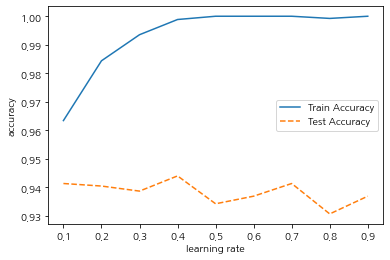

In [11]:
#모델 설명력 그래프 확인
plt.plot(para_lr, train_accuracy, linestyle = "-", label = 'Train Accuracy')
plt.plot(para_lr, test_accuracy, linestyle = "--", label = 'Test Accuracy')
plt.xlabel('learning rate')
plt.ylabel('accuracy')
plt.legend()

In [12]:
learning_rate = 0.1

### n_estimators: 트리 수 변경에 따른 모델 성능

In [15]:
#train 및 test 설명력 결과 저장
train_accuracy = []
test_accuracy = []

### n_estimators: 트리 수 변경 1~100

para_n_tree = [n_tree * 10 for n_tree in range(1,16)]
for v_n_estimators in para_n_tree:
    rf = GBC(random_state = 1234 , learning_rate = 0.1,
             n_estimators = v_n_estimators)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))
    
#결과 저장
df_score_n = pd.DataFrame()
df_score_n['n_estimators'] = para_n_tree
df_score_n['Trainaccuracy'] = train_accuracy
df_score_n['Testaccuracy'] = test_accuracy
df_score_n.round(3)

,n_estimators,Trainaccuracy,Testaccuracy
0,10,0.933,0.928
1,20,0.939,0.932
2,30,0.947,0.936
3,40,0.952,0.940
4,50,0.956,0.940
5,60,0.957,0.940
6,70,0.957,0.939
7,80,0.960,0.939
8,90,0.961,0.940
9,100,0.963,0.941


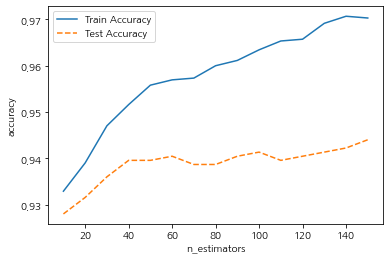

In [16]:
#모델 설명력 그래프 확인
plt.plot(para_n_tree, train_accuracy, linestyle = "-", label = 'Train Accuracy')
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = 'Test Accuracy')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.legend()

In [17]:
n_estimators = 100

### max_depth: 최대 깊이 변경에 따른 모델 성능


In [20]:
#max_depth: 최대 깊이 변경에 따른 모델 성능
#train 및 test 설명력 결과 저장
train_accuracy = []
test_accuracy = []

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree = GBC(random_state = 1234, learning_rate = 0.1,
                                  n_estimators = 100,
                                 max_depth = v_max_depth)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))

#결과 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['Depth'] = para_depth
df_accuracy_depth['TrainScore'] = train_accuracy
df_accuracy_depth['TestScore'] = test_accuracy
df_accuracy_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.936,0.935
1,2,0.951,0.940
2,3,0.963,0.941
3,4,0.979,0.945
4,5,0.990,0.940
5,6,0.998,0.949
6,7,1.000,0.947
7,8,1.000,0.948
8,9,1.000,0.950
9,10,1.000,0.947


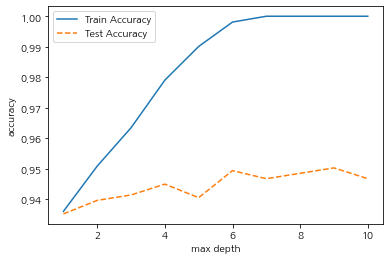

In [21]:
#모델 설명력 그래프 확인
plt.plot(para_depth, train_accuracy, linestyle = "-", label = 'Train Accuracy')
plt.plot(para_depth, test_accuracy, linestyle = "--", label = 'Test Accuracy')
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.legend()

In [23]:
max_depth = 4

### min_samples_split : 분리 노드의 최소 자료 수 변경에 따른 모델 성능

In [25]:
#train 및 test 설명력 결과 저장
train_accuracy = []
test_accuracy = []

#min_samples_split : 분리노드 최소 자료 수 * 참조 : para_split : [1,2,3,...,19]

para_split = [n_split * 10 for n_split in range(1,11)]

for v_min_samples_split in para_split:
    tree = GBC(random_state = 1234, learning_rate = 0.1,
                                n_estimators = 100,
                                 max_depth = 4,
                                 min_samples_split = v_min_samples_split)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))

#결과 저장
df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['Trainaccuracy'] = train_accuracy
df_score_split['Testaccuracy'] = test_accuracy
df_score_split.round(3)

,MinSamplesSplit,Trainaccuracy,Testaccuracy
0,10,0.977,0.945
1,20,0.976,0.942
2,30,0.974,0.942
3,40,0.973,0.937
4,50,0.969,0.941
5,60,0.973,0.941
6,70,0.969,0.943
7,80,0.968,0.943
8,90,0.966,0.941
9,100,0.963,0.940


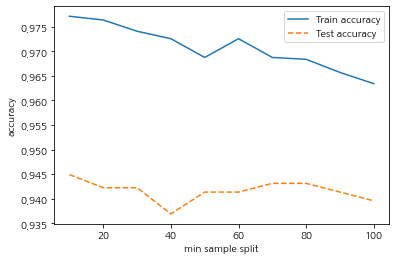

In [26]:
#모델 설명력 그래프 확인
plt.plot(para_split, train_accuracy, linestyle = "-", label = 'Train accuracy')
plt.plot(para_split, test_accuracy, linestyle = "--", label = 'Test accuracy')
plt.xlabel('min sample split')
plt.ylabel('accuracy')
plt.legend()

### min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [28]:
#train 및 test 설명력 결과 저장
train_accuracy = []
test_accuracy = []

#min_samples_leaf : 잎사귀 최소 자료 수 * 참조 : para_leaf : [1,2,3,...,19]

para_leaf = [n_leaf * 10 for n_leaf in range(1,11)]
for v_min_samples_leaf in para_leaf:
    tree = GBC(random_state = 1234 , n_estimators = 100, learning_rate = 0.1,
                                  min_samples_leaf = v_min_samples_leaf,
                                  max_depth = 4)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))
    
#결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainAccuracy'] = train_accuracy
df_score_leaf['TestAccuracy'] = test_accuracy
#모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,10,0.977,0.946
1,20,0.970,0.942
2,30,0.970,0.942
3,40,0.963,0.940
4,50,0.960,0.942
5,60,0.958,0.939
6,70,0.958,0.937
7,80,0.955,0.940
8,90,0.950,0.936
9,100,0.948,0.938


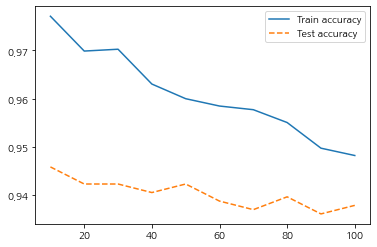

In [29]:
#모델 설명력 그래프 확인
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = 'Train accuracy')
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = 'Test accuracy')
plt.legend()

In [30]:
min_samples_leaf = 10

### 최종 모델 선정

Accuracy on training set : 0.977
Accuracy on test set : 0.946


In [35]:
y_pred = gb_final.predict(df_test_x)
print('Accuracy: {0:3f}\n'.format(gb_final.score(df_test_x, df_test_y)))
print('Confusion matrix : \n{}'.format(confusion_matrix(df_test_y, y_pred)))

Accuracy: 0.945778

Confusion matrix : 
[[1018    3]
 [  58   46]]


### 결론 도출
### feature_importances_ : 설명변수의 중요도

In [37]:
#변수명 저장
v_feature_name = df_train_x.columns

#나무를 만들 때 사용되는 변수들의 중요도
#feature_importances_ : 설명변수의 중요도
#tree_final, feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = gb_final.feature_importances_

#df_feature_importance 의 테이블을 중요도별로 정렬
df_importance.sort_values('Importance', ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
9,DEBTINC,0.327
6,CLAGE,0.120
2,VALUE,0.107
8,CLNO,0.105
5,DELINQ,0.100
0,LOAN,0.072
1,MORTDUE,0.041
7,NINQ,0.038
4,DEROG,0.034
3,YOJ,0.033


Text(0, 0.5, '설명변수')

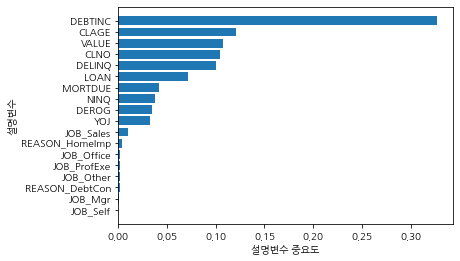

In [38]:
#설명변수 중요도 그래프, 중요도가 높은 변수를 상위에 그림
df_importance.sort_values('Importance', ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')

### GridSearchCV 를 이용한 최적 parameter 찾기

In [39]:
estimator = GBC(n_estimators = 100, random_state =1234)

#구하고자 하는 parameter 와 범위
param_grid = {'learning_rate': para_lr, 
              'max_depth' : para_depth, 'min_samples_leaf': para_leaf}

#정확도가 높은 최적 parameter 찾기
grid_gb = GridSearchCV(estimator, param_grid, scoring = 'accuracy', n_jobs =-1)
grid_gb.fit(df_train_x, df_train_y)

print(f'best estimator model : \n {grid_gb.best_estimator_}')
print(f'\nbest parameter : \n {grid_gb.best_params_}')
print(f'\nbest score : \n {grid_gb.best_score_.round(3)}')

best estimator model : 
 GradientBoostingClassifier(learning_rate=0.30000000000000004, max_depth=8,
                           min_samples_leaf=10, random_state=1234)

best parameter : 
 {'learning_rate': 0.30000000000000004, 'max_depth': 8, 'min_samples_leaf': 10}

best score : 
 0.957
